In [ ]:
pip install kagglehub

## Importing dataset

In [1]:
import os
from PIL import Image
import glob

# Specify the path to the dataset in your local repository
dataset_path = '/Users/apple/Desktop/PG/SEM-3/BIOS-511/bios-final/data'

# Check if the directory exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"The specified path {dataset_path} does not exist.")

# List all image files in the directory (assuming jpg and png images)
image_files = glob.glob(os.path.join(dataset_path, '**/*.jpg'), recursive=True)
image_files += glob.glob(os.path.join(dataset_path, '**/*.png'), recursive=True)

# Check if images are found
if not image_files:
    print("No images found in the specified directory.")
else:
    print(f"Found {len(image_files)} images in the dataset.")

# Load and display a sample image to confirm the dataset is accessible
sample_image = Image.open(image_files[0])
sample_image.show()  # Opens the first image in your default image viewer

# Optional: Load all images (for further processing)
images = [Image.open(img_path) for img_path in image_files]

print("Dataset successfully loaded from local repository.")


Found 9208 images in the dataset.
Dataset successfully loaded from local repository.


In [2]:
import os
import shutil
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os

dataset_path = '/Users/apple/Desktop/PG/SEM-3/BIOS-511/bios-final/data'
output_path = '/Users/apple/Desktop/PG/SEM-3/BIOS-511/bios-final/processed_data'

if not os.path.exists(output_path):
    os.makedirs(output_path)

## Finetuning and Augmenting Dataset

In [4]:
classes = ['Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral', 'COVID-19']

In [6]:
class_counts = {}
for cls in classes:
    class_dir = os.path.join(dataset_path, cls)
    class_counts[cls] = len(os.listdir(class_dir))

max_count = max(class_counts.values())
print("Class counts before balancing:", class_counts)

Class counts before balancing: {'Normal': 3270, 'Pneumonia-Bacterial': 3001, 'Pneumonia-Viral': 1656, 'COVID-19': 1281}


In [7]:
def augment_images(image_paths, num_new_images, save_dir):
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    num_generated = 0
    while num_generated < num_new_images:
        for img_path in image_paths:
            img = Image.open(img_path)
            img = img.resize((224, 224))
            x = np.array(img)
            x = x.reshape((1,) + x.shape)

            prefix = os.path.splitext(os.path.basename(img_path))[0]
            for batch in datagen.flow(x, batch_size=1, save_to_dir=save_dir, save_prefix=prefix, save_format='jpg'):
                num_generated += 1
                if num_generated >= num_new_images:
                    break
        if num_generated >= num_new_images:
            break


In [8]:
target_count = 3500  # Adjust as needed

for cls in classes:
    class_dir = os.path.join(dataset_path, cls)
    images = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir)]
    current_count = len(images)
    save_dir = os.path.join(output_path, cls)
    os.makedirs(save_dir, exist_ok=True)
    
    # Copy existing images
    for img_path in images:
        shutil.copy(img_path, save_dir)
    
    # Augment images if needed
    if current_count < target_count:
        num_new_images = target_count - current_count
        augment_images(images, num_new_images, save_dir)
    elif current_count > target_count:
        # Randomly select images to match target_count
        images_to_keep = random.sample(images, target_count)
        for img_path in images:
            if img_path not in images_to_keep:
                os.remove(os.path.join(save_dir, os.path.basename(img_path)))
    
    print(f"Class {cls} balanced to {target_count} images.")


Class Normal balanced to 3500 images.
Class Pneumonia-Bacterial balanced to 3500 images.
Class Pneumonia-Viral balanced to 3500 images.
Class COVID-19 balanced to 3500 images.


In [9]:
train_dir = os.path.join(output_path, 'train')
val_dir = os.path.join(output_path, 'validation')
test_dir = os.path.join(output_path, 'test')

for cls in classes:
    class_dir = os.path.join(output_path, cls)
    images = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir)]
    
    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)
    
    # Function to copy images to destination
    def copy_images(image_list, destination):
        dest_dir = os.path.join(destination, cls)
        os.makedirs(dest_dir, exist_ok=True)
        for img_path in image_list:
            shutil.move(img_path, os.path.join(dest_dir, os.path.basename(img_path)))
    
    copy_images(train_images, train_dir)
    copy_images(val_images, val_dir)
    copy_images(test_images, test_dir)


##  Creating Generators

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
img_height, img_width = 224, 224  # Input size for the model
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)


In [12]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)


Found 15950 images belonging to 4 classes.
Found 3419 images belonging to 4 classes.
Found 3420 images belonging to 4 classes.


## Model

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

In [14]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model
base_model.trainable = False

2024-11-11 18:19:04.676665: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-11-11 18:19:04.676814: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-11-11 18:19:04.677057: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-11-11 18:19:04.677116: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-11 18:19:04.677492: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


## Training the Model

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#'best_model.h5' = '/Users/apple/Desktop/PG/SEM-3/BIOS-511/bios-final'
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)

callbacks_list = [checkpoint, earlystop, reduce_lr]

In [27]:
epochs = 20

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/20


2024-11-11 18:27:38.723973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/apple/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.3481 - loss: 1.6031
Epoch 1: val_accuracy improved from -inf to 0.75531, saving model to best_model.keras
498/498 ━━━━━━━━━━━━━━━━━━━━ 268s 516ms/step - accuracy: 0.3483 - loss: 1.6026 - val_accuracy: 0.7553 - val_loss: 0.7470 - learning_rate: 1.0000e-04
Epoch 2/20
  1/498 ━━━━━━━━━━━━━━━━━━━━ 4:51 587ms/step - accuracy: 0.6875 - loss: 0.9056

2024-11-11 18:32:05.992625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-11 18:32:05.992663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_4/_14]]
2024-11-11 18:32:05.992687: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6265510389303259536
2024-11-11 18:32:05.992706: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15092720437061352747
2024-11-11 18:32:05.992747: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13013942275407847042
2024-11-11 18:32:05.992769: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 178963974


Epoch 2: val_accuracy did not improve from 0.75531
498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6875 - loss: 0.9056 - val_accuracy: 0.7037 - val_loss: 0.9144 - learning_rate: 1.0000e-04
Epoch 3/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6124 - loss: 0.9432
Epoch 3: val_accuracy improved from 0.75531 to 0.79481, saving model to best_model.keras
498/498 ━━━━━━━━━━━━━━━━━━━━ 204s 406ms/step - accuracy: 0.6125 - loss: 0.9431 - val_accuracy: 0.7948 - val_loss: 0.5918 - learning_rate: 1.0000e-04
Epoch 4/20
  1/498 ━━━━━━━━━━━━━━━━━━━━ 3:18 400ms/step - accuracy: 0.6250 - loss: 0.7943

2024-11-11 18:35:33.220492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-11 18:35:33.220779: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17896397439716306512
2024-11-11 18:35:33.221030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add/_16]]
2024-11-11 18:35:33.221069: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7078480021521055205
2024-11-11 18:35:33.221377: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5707917327382006617
2024-11-11 18:35:33.221433: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 177334672115


Epoch 4: val_accuracy improved from 0.79481 to 0.81481, saving model to best_model.keras
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6250 - loss: 0.7943 - val_accuracy: 0.8148 - val_loss: 0.6145 - learning_rate: 1.0000e-04
Epoch 5/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.7063 - loss: 0.7466
Epoch 5: val_accuracy did not improve from 0.81481
498/498 ━━━━━━━━━━━━━━━━━━━━ 209s 416ms/step - accuracy: 0.7063 - loss: 0.7466 - val_accuracy: 0.8110 - val_loss: 0.5303 - learning_rate: 1.0000e-04
Epoch 6/20
  1/498 ━━━━━━━━━━━━━━━━━━━━ 3:46 456ms/step - accuracy: 0.6875 - loss: 0.7640

2024-11-11 18:39:04.551330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/ReadVariableOp_2/_1]]
2024-11-11 18:39:04.551736: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6265510389303259536
2024-11-11 18:39:04.551939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-11 18:39:04.551950: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12156489212182485764
2024-11-11 18:39:04.551957: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15092720437061352747
2024-11-11 18:39:04.551962: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash:


Epoch 6: val_accuracy did not improve from 0.81481
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6875 - loss: 0.7640 - val_accuracy: 0.7778 - val_loss: 0.4859 - learning_rate: 1.0000e-04
Epoch 7/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7341 - loss: 0.6654
Epoch 7: val_accuracy improved from 0.81481 to 0.81899, saving model to best_model.keras
498/498 ━━━━━━━━━━━━━━━━━━━━ 211s 421ms/step - accuracy: 0.7341 - loss: 0.6653 - val_accuracy: 0.8190 - val_loss: 0.4991 - learning_rate: 1.0000e-04
Epoch 8/20
  1/498 ━━━━━━━━━━━━━━━━━━━━ 3:36 436ms/step - accuracy: 0.7188 - loss: 0.6100

2024-11-11 18:42:37.208603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-11 18:42:37.209100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_32]]
2024-11-11 18:42:37.209741: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4256602424012500685
2024-11-11 18:42:37.209749: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5707917327382006617
2024-11-11 18:42:37.209753: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17750998205797025213
2024-11-11 18:42:37.209757: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7078480021521055205
2024-11-1


Epoch 8: val_accuracy improved from 0.81899 to 0.88889, saving model to best_model.keras


2024-11-11 18:42:37.802784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-11 18:42:37.802813: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11738047546175963741
2024-11-11 18:42:37.803757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[ArgMax_1/_14]]


498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7188 - loss: 0.6100 - val_accuracy: 0.8889 - val_loss: 0.3016 - learning_rate: 1.0000e-04
Epoch 9/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.7472 - loss: 0.6385
Epoch 9: val_accuracy did not improve from 0.88889
498/498 ━━━━━━━━━━━━━━━━━━━━ 196s 389ms/step - accuracy: 0.7472 - loss: 0.6385 - val_accuracy: 0.8234 - val_loss: 0.4761 - learning_rate: 1.0000e-04
Epoch 10/20
  1/498 ━━━━━━━━━━━━━━━━━━━━ 3:13 390ms/step - accuracy: 0.7812 - loss: 0.4315

2024-11-11 18:45:54.600322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-11 18:45:54.600768: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17896397439716306512
2024-11-11 18:45:54.600775: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7078480021521055205
2024-11-11 18:45:54.600779: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5707917327382006617
2024-11-11 18:45:54.600783: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17750998205797025213
2024-11-11 18:45:54.600787: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4256602424012500685
2024-11-11 18:45:54.600791: I tensorflow/core/framework/local_rendezv


Epoch 10: val_accuracy did not improve from 0.88889
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7812 - loss: 0.4315 - val_accuracy: 0.7778 - val_loss: 0.5350 - learning_rate: 1.0000e-04
Epoch 11/20


2024-11-11 18:45:55.120349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-11 18:45:55.120383: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11738047546175963741
2024-11-11 18:45:55.120751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[ArgMax_1/_14]]


498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.7729 - loss: 0.5848
Epoch 11: val_accuracy did not improve from 0.88889

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
498/498 ━━━━━━━━━━━━━━━━━━━━ 196s 390ms/step - accuracy: 0.7729 - loss: 0.5847 - val_accuracy: 0.8249 - val_loss: 0.4623 - learning_rate: 1.0000e-04
Epoch 12/20
  1/498 ━━━━━━━━━━━━━━━━━━━━ 3:13 389ms/step - accuracy: 0.7188 - loss: 0.5923

2024-11-11 18:49:11.704976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]
2024-11-11 18:49:11.705867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-11 18:49:11.706591: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6265510389303259536
2024-11-11 18:49:11.706639: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17896397439716306512
2024-11-11 18:49:11.706728: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17733467211517531627
2024-11-11 18:49:11.706735: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7579822961933817388
2024-11-


Epoch 12: val_accuracy did not improve from 0.88889
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7188 - loss: 0.5923 - val_accuracy: 0.8148 - val_loss: 0.4634 - learning_rate: 2.0000e-05
Epoch 13/20


2024-11-11 18:49:12.184351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-11 18:49:12.184386: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11738047546175963741
2024-11-11 18:49:12.184595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[ArgMax_1/_14]]


498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7804 - loss: 0.5610
Epoch 13: val_accuracy did not improve from 0.88889
498/498 ━━━━━━━━━━━━━━━━━━━━ 203s 404ms/step - accuracy: 0.7804 - loss: 0.5610 - val_accuracy: 0.8269 - val_loss: 0.4551 - learning_rate: 2.0000e-05
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.


## Finetuning the Model

In [30]:
# Unfreeze the last 10 layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    callbacks=callbacks_list
)

Epoch 1/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.6162 - loss: 1.0829
Epoch 1: val_accuracy did not improve from 0.88889
498/498 ━━━━━━━━━━━━━━━━━━━━ 229s 439ms/step - accuracy: 0.6163 - loss: 1.0826 - val_accuracy: 0.8196 - val_loss: 0.5106 - learning_rate: 1.0000e-05
Epoch 2/10
  1/498 ━━━━━━━━━━━━━━━━━━━━ 3:20 403ms/step - accuracy: 0.8125 - loss: 0.6184

2024-11-11 18:57:36.518661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_28]]
2024-11-11 18:57:36.519114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-11 18:57:36.519142: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7736248736809865372
2024-11-11 18:57:36.519170: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7741281543434991978
2024-11-11 18:57:36.519180: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12292661835095124728
2024-11-11 18:57:36.519186: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12994970585488093413
2024-11-


Epoch 2: val_accuracy did not improve from 0.88889
498/498 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8125 - loss: 0.6184 - val_accuracy: 0.8519 - val_loss: 0.3508 - learning_rate: 1.0000e-05
Epoch 3/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.7452 - loss: 0.6904
Epoch 3: val_accuracy did not improve from 0.88889
498/498 ━━━━━━━━━━━━━━━━━━━━ 221s 439ms/step - accuracy: 0.7452 - loss: 0.6904 - val_accuracy: 0.8340 - val_loss: 0.4564 - learning_rate: 1.0000e-05
Epoch 4/10
  1/498 ━━━━━━━━━━━━━━━━━━━━ 3:24 412ms/step - accuracy: 0.7812 - loss: 0.9100

2024-11-11 19:01:19.906480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_28]]
2024-11-11 19:01:19.906902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-11 19:01:19.906916: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12994970585488093413
2024-11-11 19:01:19.906922: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15795060851507271129
2024-11-11 19:01:19.906926: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7736248736809865372
2024-11-11 19:01:19.906935: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 764510874015692513
2024-11-1


Epoch 4: val_accuracy did not improve from 0.88889
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7812 - loss: 0.9100 - val_accuracy: 0.8519 - val_loss: 0.5395 - learning_rate: 1.0000e-05
Epoch 5/10


2024-11-11 19:01:20.345554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-11 19:01:20.345584: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11738047546175963741
2024-11-11 19:01:20.345853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[ArgMax_1/_14]]


498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.7674 - loss: 0.6344
Epoch 5: val_accuracy did not improve from 0.88889

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
498/498 ━━━━━━━━━━━━━━━━━━━━ 211s 421ms/step - accuracy: 0.7674 - loss: 0.6344 - val_accuracy: 0.8361 - val_loss: 0.4413 - learning_rate: 1.0000e-05
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


## Evaluating Results

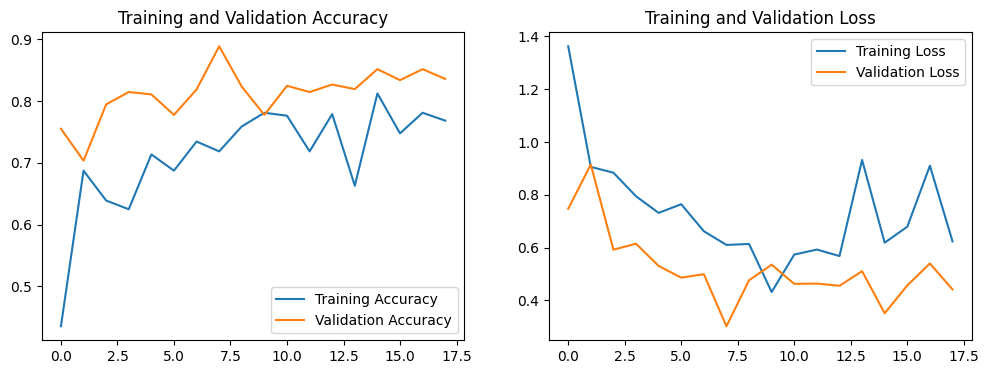

In [33]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history.get('accuracy', []) + history_fine.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', []) + history_fine.history.get('val_accuracy', [])
    loss = history.history.get('loss', []) + history_fine.history.get('loss', [])
    val_loss = history.history.get('val_loss', []) + history_fine.history.get('val_loss', [])
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)


In [34]:
# Evaluating based on the test dataset
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Accuracy: {test_acc:.2f}')


/Users/apple/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 42s 388ms/step - accuracy: 0.9175 - loss: 0.2517
Test Accuracy: 0.82


107/107 ━━━━━━━━━━━━━━━━━━━━ 43s 344ms/step
Classification Report
                     precision    recall  f1-score   support

           COVID-19       0.85      0.99      0.91       682
             Normal       0.91      0.89      0.90      1015
Pneumonia-Bacterial       0.74      0.75      0.75       972
    Pneumonia-Viral       0.73      0.62      0.67       751

           accuracy                           0.81      3420
          macro avg       0.81      0.81      0.81      3420
       weighted avg       0.81      0.81      0.81      3420



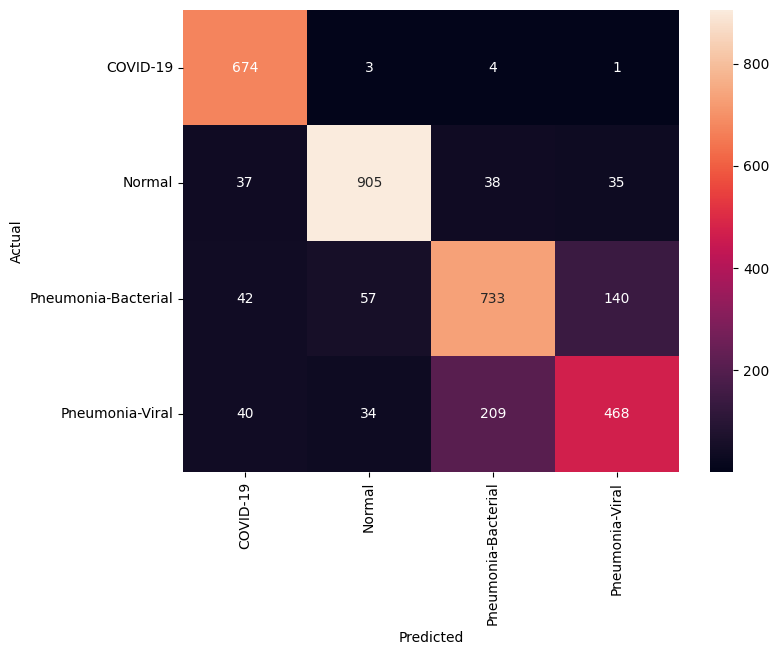

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Predict the labels of the test set
Y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Classification Report
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## Saving the Model

In [36]:
model.save('pneumonia_classifier_final.h5')

## Future steps: Model Interpretability with Grad-CAM

In [37]:
import cv2
import tensorflow.keras.backend as K

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    # Compute the gradient of the top predicted class
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    # Pool the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # Multiply each channel
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # Apply ReLU and normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [38]:
# Using function with a sample image
import matplotlib.cm as cm

# Load an image from the test set
img_path = test_generator.filepaths[0]
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Generate Grad-CAM heatmap
last_conv_layer_name = 'conv5_block16_concat'  # Layer name in DenseNet121
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Superimpose heatmap on the image
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap_color * 0.4 + img
cv2.imwrite('gradcam.jpg', superimposed_img)


ValueError: When providing `inputs` as a list/tuple, all values in the list/tuple must be KerasTensors. Received: inputs=[[<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor>]] including invalid value [<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor>] of type <class 'list'>